In [4]:
import numpy as np
from scipy.stats import dirichlet
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import gamma
from scipy.stats import beta

def an_post(index, hm, xt, alpha):
    w0x = np.arange(1e-6, 1, 1/hm)
    x = tqdm.tqdm( w0x)
    w0y = []
    for w0 in x:
        w1x = np.arange(1e-6, 1-w0, 1/hm)
        w1y = []
        for w1 in w1x:
            w2 = 1-w0-w1
            if index == 0: w1y.append( np.exp( log_posterior(xt, np.array([w0, w1, w2]), alpha  ) ) ) 
            elif index == 1: w1y.append( np.exp( log_posterior(xt, np.array([w1, w0, w2]), alpha  ) ) ) 
            else: w1y.append( np.exp( log_posterior(xt, np.array([w2, w1, w0]), alpha  ) ) ) 
        w0y.append( np.trapz( np.array(w1y), w1x) )
    y = np.array(w0y)
    return w0x, y/np.trapz(y, w0x)

def an_proposal(index, hm, xt, alpha):
    w0x = np.arange(1e-6, 1, 1/hm)
    x = tqdm.tqdm( w0x)
    w0y = []
    for w0 in x:
        w1x = np.arange(1e-6, 1-w0, 1/hm)
        w1y = []
        for w1 in w1x:
            w2 = 1-w0-w1
            if index == 0: w1y.append( np.exp( dirichlet.logpdf( np.array([w0, w1, w2]), alpha = alpha  ) ) ) 
            elif index == 1: w1y.append( np.exp( dirichlet.logpdf( np.array([w1, w0, w2]), alpha = alpha  ) ) ) 
            else: w1y.append( np.exp( dirichlet.logpdf( np.array([w2, w1, w0]), alpha = alpha  ) ) ) 
        w0y.append( np.trapz( np.array(w1y), w1x) )
    y = np.array(w0y)
    return w0x, y/np.trapz(y, w0x)

def an_prior(index, hm, xt, alpha):
    w0x = np.arange(1e-6, 1, 1/hm)
    x = tqdm.tqdm( w0x)
    w0y = []
    for w0 in x:
        w1x = np.arange(1e-6, 1-w0, 1/hm)
        w1y = []
        for w1 in w1x:
            w2 = 1-w0-w1
            if index == 0: w1y.append( np.exp( dirichlet.logpdf( np.array([w0, w1, w2]), alpha = alpha  ) ) ) 
            elif index == 1: w1y.append( np.exp( dirichlet.logpdf( np.array([w1, w0, w2]), alpha = alpha  ) ) ) 
            else: w1y.append( np.exp( dirichlet.logpdf( np.array([w2, w1, w0]), alpha = alpha  ) ) ) 
        w0y.append( np.trapz( np.array(w1y), w1x) )
    y = np.array(w0y)
    return w0x, y/np.trapz(y, w0x)

def an_lik(index, hm, xt, alpha):
    w0x = np.arange(1e-6, 1, 1/hm)
    x = tqdm.tqdm( w0x)
    w0y = []
    for w0 in x:
        w1x = np.arange(1e-6, 1-w0, 1/hm)
        w1y = []
        for w1 in w1x:
            w2 = 1-w0-w1
            if index == 0: w1y.append( np.exp( loglikelihood(xt, np.array([w0, w1, w2]) ) ) ) 
            elif index == 1: w1y.append( np.exp( loglikelihood(xt, np.array([w1, w0, w2]) ) ) ) 
            else: w1y.append( np.exp( loglikelihood(xt, np.array([w2, w1, w0]) ) ) ) 
        w0y.append( np.trapz( np.array(w1y), w1x) )
    y = np.array(w0y)
    return w0x, y/np.trapz(y, w0x)

def generate_xt(n_pars, hm):
    xt = []
    for _ in range(hm):
        temp = np.linspace(10,1,n_pars) * np.random.uniform(0,1,n_pars)
        xt.append(temp/np.sum(temp))
    return np.array(xt)

def loglikelihood(xt, omega):
    return np.sum( np.log( np.array( [ np.sum(xt[i]*omega) for i in range(len(xt)) ] ) ) )

def log_posterior(xt, omega, alpha):
    return loglikelihood(xt, omega) + dirichlet.logpdf(omega, alpha = alpha)

def sampling(n, xt, alpha, alpha_prop):
    accepted = []
    prs = []
    c = 0
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    omega = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
    for i in pb:
        acp = i and c/i or 0
        pb.set_description("Acceptance rate %f" % acp)
        omega_new = np.hstack( dirichlet.rvs(alpha = alpha_prop, size = 1) )
        pr = np.min([dirichlet.logpdf(omega_new, alpha = alpha_prop) - dirichlet.logpdf(omega, alpha = alpha_prop), 0] )
        if log_rnd[i] <= log_acceptance_diri(xt, alpha, alpha_prop, omega, omega_new):
            omega = omega_new
            c +=1
        accepted.append(omega)
        prs.append(pr)
    return np.array(accepted), np.exp(np.array(prs))

def sampling2(n, xt, alpha, eps, each):
    accepted = []
    prs = []
    c = 0
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    omega = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
    for i in pb:
        acp = i and c/i or 0
        pb.set_description("Acceptance rate %f" % acp)
        omega_pr = np.hstack( dirichlet.rvs(alpha = omega*eps, size = 1) )
        #if any(omega_pr==0): continue
        if i % each == 0: print(omega_pr)
        omega_pr = np.where(omega_pr>0, omega_pr, 1e-10)
        omega_pr = omega_pr/np.sum(omega_pr)
        pr = np.min([dirichlet.logpdf(omega_pr, alpha = omega*eps) - dirichlet.logpdf(omega, alpha = omega_pr*eps), 0] )
        if log_rnd[i] <= log_acceptance(xt, alpha, omega, omega_pr, eps):
            omega = omega_pr
            c +=1
        accepted.append(omega)
        prs.append(pr)
    return np.array(accepted), np.exp(np.array(prs))

def log_acceptance_diri(xt, alpha, alpha_prop, omega, omega_pr):
    #print(dirichlet.logpdf(omega_pr, alpha = alpha) - dirichlet.logpdf(omega, alpha = alpha))
    return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) - dirichlet.logpdf(omega_pr, alpha = alpha_prop) + dirichlet.logpdf(omega, alpha = alpha_prop)

def log_acceptance(xt, alpha, omega, omega_pr, eps):
            return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) - dirichlet.logpdf(omega_pr, alpha = omega*eps) + dirichlet.logpdf(omega, alpha = omega_pr*eps)
            #return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) + log_jacobian(x_pr) - log_jacobian(x) + norm.logpdf(np.sum(x_pr), loc = 1, scale = 0.1) - norm.logpdf(np.sum(x), loc = 1, scale = 0.1) - np.sum( gamma.logpdf(x_pr, a = alp, scale=scale) ) + np.sum( gamma.logpdf(x, a = alp, scale=scale_reverse) )

def log_jacobian(x):
    return -(len(x)) * np.log(np.sum(x))



In [2]:
def w1_post(w1arr, alpha, xt):
    a1,a2,a3 = alpha
    x1,y1,z1 = xt[0]
    x2,y2,z2 = xt[1]
    x3,y3,z3 = xt[2]
    y = []
    for w1 in w1arr:
        y.append( ((1-w1)**(-1+a2+a3)*w1**(-1+a1)*(-a2*(1+a2)*(2+a2)*(-1+w1)**3*y1*y2*y3+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y2*y3*(x1-z1)+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y2*y3*z1+a2*(1+a2)*(2+a2)*(-1+w1)**3*y2*y3*z1+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y1*y3*(x2-z2)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*y3*(x1-z1)*(x2-z2)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y3*z1*(x2-z2)-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y3*z1*(x2-z2)+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y1*y3*z2+a2*(1+a2)*(2+a2)*(-1+w1)**3*y1*y3*z2-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y3*(x1-z1)*z2-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y3*(x1-z1)*z2-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*y3*z1*z2-2*a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y3*z1*z2-a2*(1+a2)*(2+a2)*(-1+w1)**3*y3*z1*z2+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y1*y2*(x3-z3)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*y2*(x1-z1)*(x3-z3)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y2*z1*(x3-z3)-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y2*z1*(x3-z3)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*y1*(x2-z2)*(x3-z3)+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1**3*(x1-z1)*(x2-z2)*(x3-z3)+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1**2*z1*(x2-z2)*(x3-z3)+a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*z1*(x2-z2)*(x3-z3)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y1*z2*(x3-z3)-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y1*z2*(x3-z3)+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1**2*(x1-z1)*z2*(x3-z3)+a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*(x1-z1)*z2*(x3-z3)+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1*z1*z2*(x3-z3)+2*a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*z1*z2*(x3-z3)+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*z1*z2*(x3-z3)+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y1*y2*z3+a2*(1+a2)*(2+a2)*(-1+w1)**3*y1*y2*z3-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y2*(x1-z1)*z3-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y2*(x1-z1)*z3-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*y2*z1*z3-2*a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y2*z1*z3-a2*(1+a2)*(2+a2)*(-1+w1)**3*y2*z1*z3-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y1*(x2-z2)*z3-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y1*(x2-z2)*z3+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1**2*(x1-z1)*(x2-z2)*z3+a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*(x1-z1)*(x2-z2)*z3+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1*z1*(x2-z2)*z3+2*a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*z1*(x2-z2)*z3+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*z1*(x2-z2)*z3-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*y1*z2*z3-2*a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y1*z2*z3-a2*(1+a2)*(2+a2)*(-1+w1)**3*y1*z2*z3+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1*(x1-z1)*z2*z3+2*a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*(x1-z1)*z2*z3+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*(x1-z1)*z2*z3+(a2+a3)*(1+a2+a3)*(2+a2+a3)*z1*z2*z3+3*a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*z1*z2*z3+3*a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*z1*z2*z3+a2*(1+a2)*(2+a2)*(-1+w1)**3*z1*z2*z3))/((a2+a3)*(1+a2+a3)*(2+a2+a3)) )
    y = np.array(y)
    return y/np.trapz(y,w1arr)

def w2_post(w2arr, alpha, xt):
    a1,a2,a3 = alpha
    x1,y1,z1 = xt[0]
    x2,y2,z2 = xt[1]
    x3,y3,z3 = xt[2]
    y = []
    for w2 in w2arr:
        y.append( ((1-w2)**(-1+a1+a3)*w2**(-1+a2)*(-a1*(1+a1)*(2+a1)*(-1+w2)**3*x1*x2*x3+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x2*x3*(y1-z1)+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x2*x3*z1+a1*(1+a1)*(2+a1)*(-1+w2)**3*x2*x3*z1+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x1*x3*(y2-z2)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*x3*(y1-z1)*(y2-z2)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x3*z1*(y2-z2)-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x3*z1*(y2-z2)+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x1*x3*z2+a1*(1+a1)*(2+a1)*(-1+w2)**3*x1*x3*z2-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x3*(y1-z1)*z2-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x3*(y1-z1)*z2-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*x3*z1*z2-2*a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x3*z1*z2-a1*(1+a1)*(2+a1)*(-1+w2)**3*x3*z1*z2+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x1*x2*(y3-z3)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*x2*(y1-z1)*(y3-z3)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x2*z1*(y3-z3)-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x2*z1*(y3-z3)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*x1*(y2-z2)*(y3-z3)+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2**3*(y1-z1)*(y2-z2)*(y3-z3)+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2**2*z1*(y2-z2)*(y3-z3)+a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*z1*(y2-z2)*(y3-z3)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x1*z2*(y3-z3)-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x1*z2*(y3-z3)+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2**2*(y1-z1)*z2*(y3-z3)+a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*(y1-z1)*z2*(y3-z3)+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2*z1*z2*(y3-z3)+2*a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*z1*z2*(y3-z3)+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*z1*z2*(y3-z3)+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x1*x2*z3+a1*(1+a1)*(2+a1)*(-1+w2)**3*x1*x2*z3-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x2*(y1-z1)*z3-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x2*(y1-z1)*z3-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*x2*z1*z3-2*a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x2*z1*z3-a1*(1+a1)*(2+a1)*(-1+w2)**3*x2*z1*z3-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x1*(y2-z2)*z3-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x1*(y2-z2)*z3+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2**2*(y1-z1)*(y2-z2)*z3+a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*(y1-z1)*(y2-z2)*z3+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2*z1*(y2-z2)*z3+2*a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*z1*(y2-z2)*z3+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*z1*(y2-z2)*z3-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*x1*z2*z3-2*a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x1*z2*z3-a1*(1+a1)*(2+a1)*(-1+w2)**3*x1*z2*z3+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2*(y1-z1)*z2*z3+2*a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*(y1-z1)*z2*z3+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*(y1-z1)*z2*z3+(a1+a3)*(1+a1+a3)*(2+a1+a3)*z1*z2*z3+3*a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*z1*z2*z3+3*a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*z1*z2*z3+a1*(1+a1)*(2+a1)*(-1+w2)**3*z1*z2*z3))/((a1+a3)*(1+a1+a3)*(2+a1+a3)) )
    y = np.array(y)
    return y/np.trapz(y,w2arr)

def w3_post(w3arr, alpha, xt):
    a1,a2,a3 = alpha
    x1,y1,z1 = xt[0]
    x2,y2,z2 = xt[1]
    x3,y3,z3 = xt[2]
    y = []
    for w3 in w3arr:
        y.append( -(((1-w3)**(-1+a1+a2)*w3**(-1+a3)*(a1**3*((-1+w3)*x1-w3*z1)*((-1+w3)*x2-w3*z2)*((-1+w3)*x3-w3*z3)+a2*(2+3*a2+a2**2)*((-1+w3)*y1-w3*z1)*((-1+w3)*y2-w3*z2)*((-1+w3)*y3-w3*z3)+a1**2*(-3*w3*z1*((-1+w3)*x2-w3*z2)*((-1+w3)*x3-w3*z3)+(-1+w3)*x1*(a2*(-1+w3)*x3*((-1+w3)*y2-w3*z2)+3*w3*z2*(x3-w3*x3+w3*z3)+(-1+w3)*x2*(3*(-1+w3)*x3+a2*(-1+w3)*y3-3*w3*z3-a2*w3*z3)+a2*w3*(y3*(z2-w3*z2)+(y2-w3*y2+2*w3*z2)*z3))+a2*((-1+w3)*x2*((-1+w3)*x3*((-1+w3)*y1-w3*z1)+w3*(y3*(z1-w3*z1)+(y1-w3*y1+2*w3*z1)*z3))-w3*((-1+w3)*x3*((-1+w3)*y2*z1+(-1+w3)*y1*z2-2*w3*z1*z2)+w3*(-((-1+w3)*y3*z1*z2)+y2*(z1-w3*z1)*z3+(y1-w3*y1+3*w3*z1)*z2*z3))))+a1*(-2*w3*z1*((-1+w3)*x2-w3*z2)*((-1+w3)*x3-w3*z3)+(-1+w3)*x1*(a2**2*((-1+w3)*y2-w3*z2)*((-1+w3)*y3-w3*z3)+2*w3*z2*(x3-w3*x3+w3*z3)+(-1+w3)*x2*(2*(-1+w3)*x3+a2*(-1+w3)*y3-2*w3*z3-a2*w3*z3)+a2*((-1+w3)*x3*((-1+w3)*y2-w3*z2)+(-1+w3)*y2*((-1+w3)*y3-2*w3*z3)+w3*z2*(-2*(-1+w3)*y3+3*w3*z3)))+a2*((-1+w3)*x3*((-1+w3)*y1*((-1+w3)*y2-2*w3*z2)+w3*z1*(-2*(-1+w3)*y2+3*w3*z2))+(-1+w3)*x2*((-1+w3)*x3*((-1+w3)*y1-w3*z1)+(-1+w3)*y1*((-1+w3)*y3-2*w3*z3)+w3*z1*(-2*(-1+w3)*y3+3*w3*z3))-w3*((-1+w3)*y2*((-1+w3)*y3*z1+(-1+w3)*y1*z3-3*w3*z1*z3)+z2*((-1+w3)*y1*((-1+w3)*y3-3*w3*z3)+3*w3*z1*(y3-w3*y3+2*w3*z3))))+a2**2*((-1+w3)*x3*((-1+w3)*y1-w3*z1)*((-1+w3)*y2-w3*z2)+(-1+w3)*x2*((-1+w3)*y1-w3*z1)*((-1+w3)*y3-w3*z3)-w3*((-1+w3)*y2*((-1+w3)*y3*z1+(-1+w3)*y1*z3-2*w3*z1*z3)+z2*((-1+w3)*y1*((-1+w3)*y3-2*w3*z3)+w3*z1*(-2*(-1+w3)*y3+3*w3*z3)))))))/((a1+a2)*(1+a1+a2)*(2+a1+a2))) )
    y = np.array(y)
    return y/np.trapz(y,w3arr)

In [3]:
n_pars = 3
hm = 3
xt = generate_xt(n_pars, hm)
print(xt)

[[0.87920809 0.03529212 0.08549979]
 [0.68587545 0.31101831 0.00310624]
 [0.53042511 0.27675726 0.19281763]]


In [5]:
a = 3
alpha = np.ones(n_pars)*a
a_prop = 3
alpha_prop = np.ones(n_pars)*a_prop

n = int(1e5)

samples, acp_probs_diri = sampling(n, xt, alpha, alpha_prop)
eps = 1
each = int(1e4)
samples2, acp_probs = sampling2(n, xt, alpha, eps, each)

Acceptance rate 0.036697:   0%|          | 123/100000 [00:00<01:21, 1226.26it/s]

[0.81645815 0.18242289 0.00111896]


Acceptance rate 0.062941:  10%|█         | 10185/100000 [00:08<01:17, 1158.26it/s]

[6.59323010e-01 3.40676990e-01 2.77504056e-11]


Acceptance rate 0.061705:  20%|██        | 20101/100000 [00:17<01:07, 1190.50it/s]

[0.92791009 0.07023391 0.001856  ]


Acceptance rate 0.061237:  30%|███       | 30183/100000 [00:25<00:58, 1188.30it/s]

[0.03945734 0.5897044  0.37083826]


Acceptance rate 0.061537:  40%|████      | 40116/100000 [00:34<00:50, 1185.31it/s]

[0.59063306 0.40041699 0.00894995]


Acceptance rate 0.062110:  50%|█████     | 50107/100000 [00:42<00:43, 1154.43it/s]

[0.39593465 0.5022167  0.10184865]


Acceptance rate 0.061522:  60%|██████    | 60167/100000 [00:51<00:33, 1200.26it/s]

[3.61945873e-01 6.38037271e-01 1.68557696e-05]


Acceptance rate 0.061480:  70%|███████   | 70123/100000 [00:59<00:25, 1192.55it/s]

[1.27120276e-02 4.28979940e-11 9.87287972e-01]


Acceptance rate 0.061411:  80%|████████  | 80175/100000 [01:08<00:15, 1261.42it/s]

[0.55029889 0.10656045 0.34314066]


Acceptance rate 0.061692:  90%|█████████ | 90130/100000 [01:16<00:07, 1262.04it/s]

[0.0348219  0.00591749 0.95926061]


Acceptance rate 0.061721: 100%|██████████| 100000/100000 [01:24<00:00, 1188.37it/s]


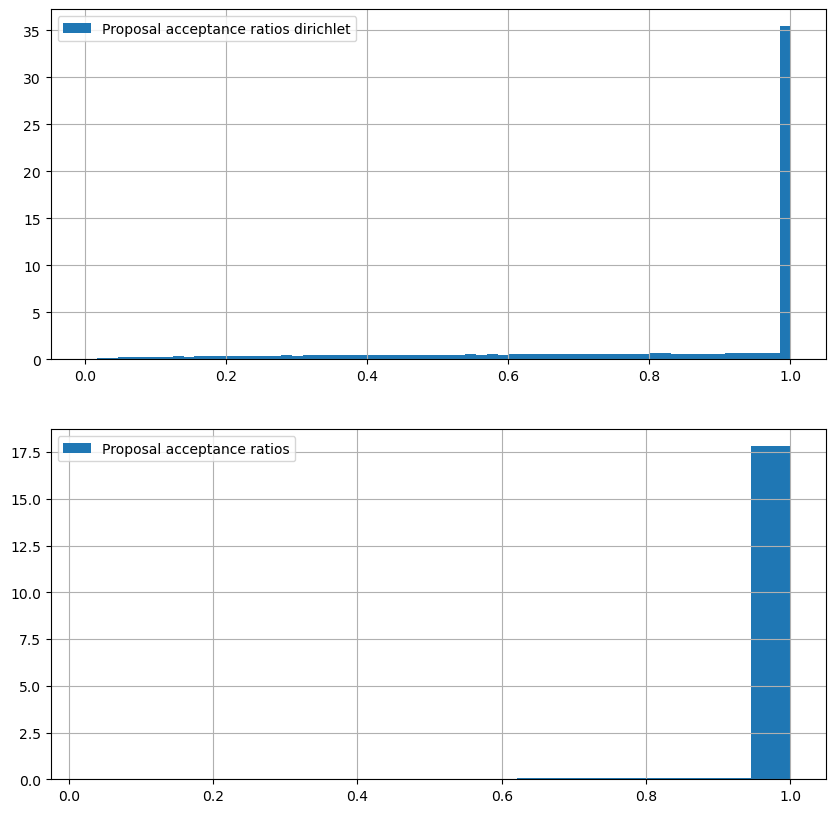

In [11]:
fig, axs = plt.subplots( 2, figsize = [10,10] )
axs[0].hist(acp_probs_diri, bins = 'auto', density = True, label = 'Proposal acceptance ratios dirichlet')
axs[0].grid()
axs[0].legend()
axs[1].hist(acp_probs, bins = 'auto', density = True, label = 'Proposal acceptance ratios')
axs[1].grid()
axs[1].legend()
plt.show()
plt.close()

In [7]:
anal_x = []
anal = []
for i in range(n_pars):
    x,y = an_post(i, 100, xt, alpha)
    anal_x.append(x)
    anal.append(y)

anal_x2 = []
anal2 = []
for i in range(n_pars):
    x,y = an_lik(i, 100, xt, alpha)
    anal_x2.append(x)
    anal2.append(y)

anal_x3 = []
anal3 = []
for i in range(n_pars):
    x,y = an_proposal(i, 100, xt, alpha_prop)
    anal_x3.append(x)
    anal3.append(y)

anal_x4 = []
anal4 = []
for i in range(n_pars):
    x,y = an_prior(i, 100, xt, alpha)
    anal_x4.append(x)
    anal4.append(y)

100%|██████████| 100/100 [00:00<00:00, 804.94it/s]


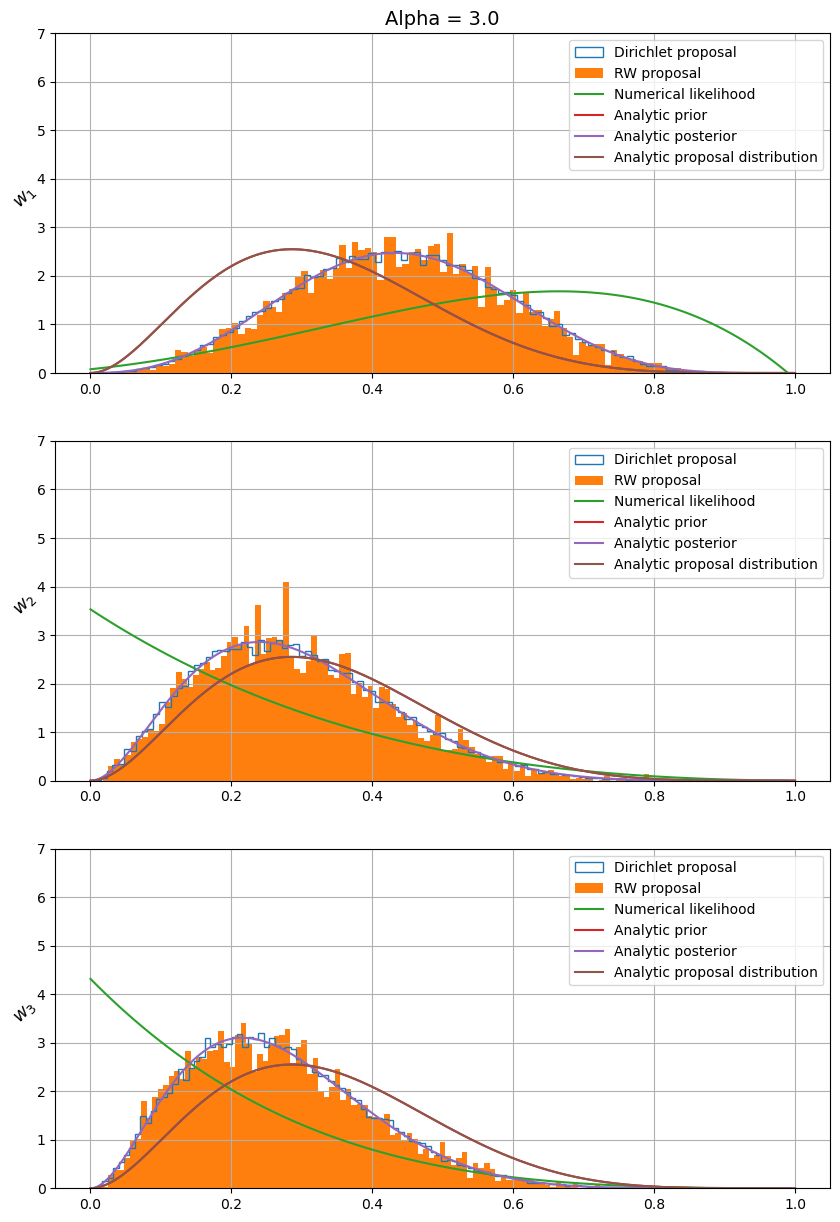

In [10]:
fig, axs = plt.subplots( n_pars, figsize = [10,15] )
w = samples
w2 = samples2[2000:]
x = np.arange(0, len(w[0]))
for i in range(n_pars):
    axs[i].hist(np.transpose(w)[i], bins = 'auto', histtype='step', density = True, label = 'Dirichlet proposal')
    axs[i].hist(np.transpose(w2)[i], bins = 'auto', density = True, label = 'RW proposal')
    axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
    #axs[i].plot(anal_x[i], anal[i], label = 'Numerical posterior')
    axs[i].plot(anal_x2[i], anal2[i], label = 'Numerical likelihood')
    #axs[i].plot(anal_x4[i], anal4[i], label = 'Numerical prior')
    axs[i].plot(np.linspace(0,1,1000), beta.pdf(np.linspace(0,1,1000), alpha[i], np.sum(alpha)-alpha[i]), label = 'Analytic prior')
    if i == 0 : 
        xx = np.linspace(1e-6,1,1000)
        axs[i].plot(xx, w1_post(xx, alpha, xt), label = 'Analytic posterior')
    if i == 1 : 
        xx = np.linspace(1e-6,1,1000)
        axs[i].plot(xx, w2_post(xx, alpha, xt), label = 'Analytic posterior')
    if i == 2 : 
        xx = np.linspace(1e-6,1,1000)
        axs[i].plot(xx, w3_post(xx, alpha, xt), label = 'Analytic posterior')
    #axs[i].plot(anal_x3[i], anal3[i], label = 'Numerical Proposal distribution')
    axs[i].plot(np.linspace(0,1,1000), beta.pdf(np.linspace(0,1,1000), alpha_prop[i], np.sum(alpha_prop)-alpha_prop[i]), label = 'Analytic proposal distribution')
    axs[i].grid()
    axs[i].legend()
    axs[i].set_ylim([0,7])
axs[0].set_title(f'Alpha = {alpha[0]}', size = 14)
#plt.savefig('alpha_prop/Alpha'+str(alpha[0])+'_prop'+str(alpha_prop[0])+'.png')
plt.show()
plt.close()

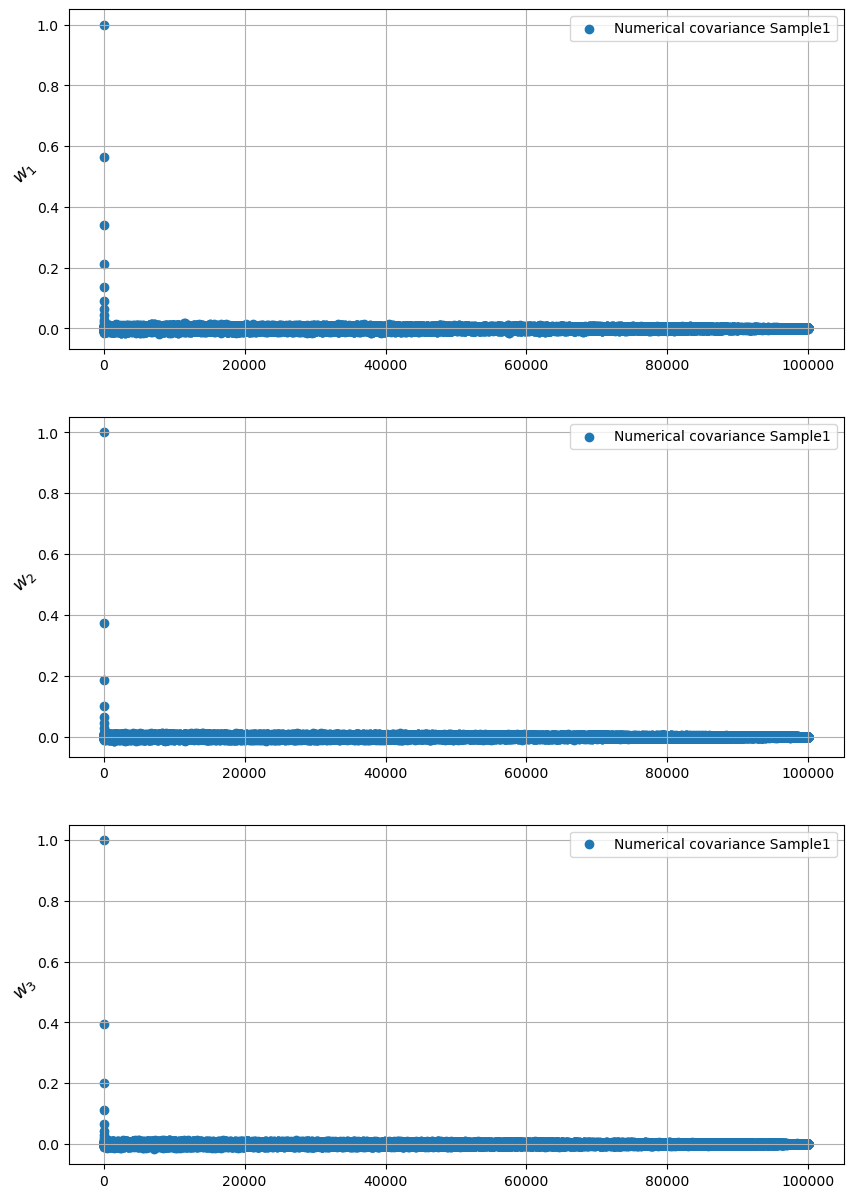

[2. 2. 2.]


In [17]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i
    
def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))
    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n
    # Optionally normalize
    if norm:
        acf /= acf[0]
    return acf

smp = np.transpose(samples)
nn = len(samples)
cors = np.zeros((n_pars,nn))

fig, axs = plt.subplots( n_pars, figsize = [10,15] )
x = np.arange(0, nn)
for i in range(n_pars):
    axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
    cors[i] = autocorr_func_1d(smp[i], norm=True)
    axs[i].scatter(x, cors[i], label = 'Numerical covariance Sample1')
    axs[i].grid()
    axs[i].legend()
plt.show()
plt.close()
taus = 1 + 2*np.sum(cors, axis = 1)
print(taus)

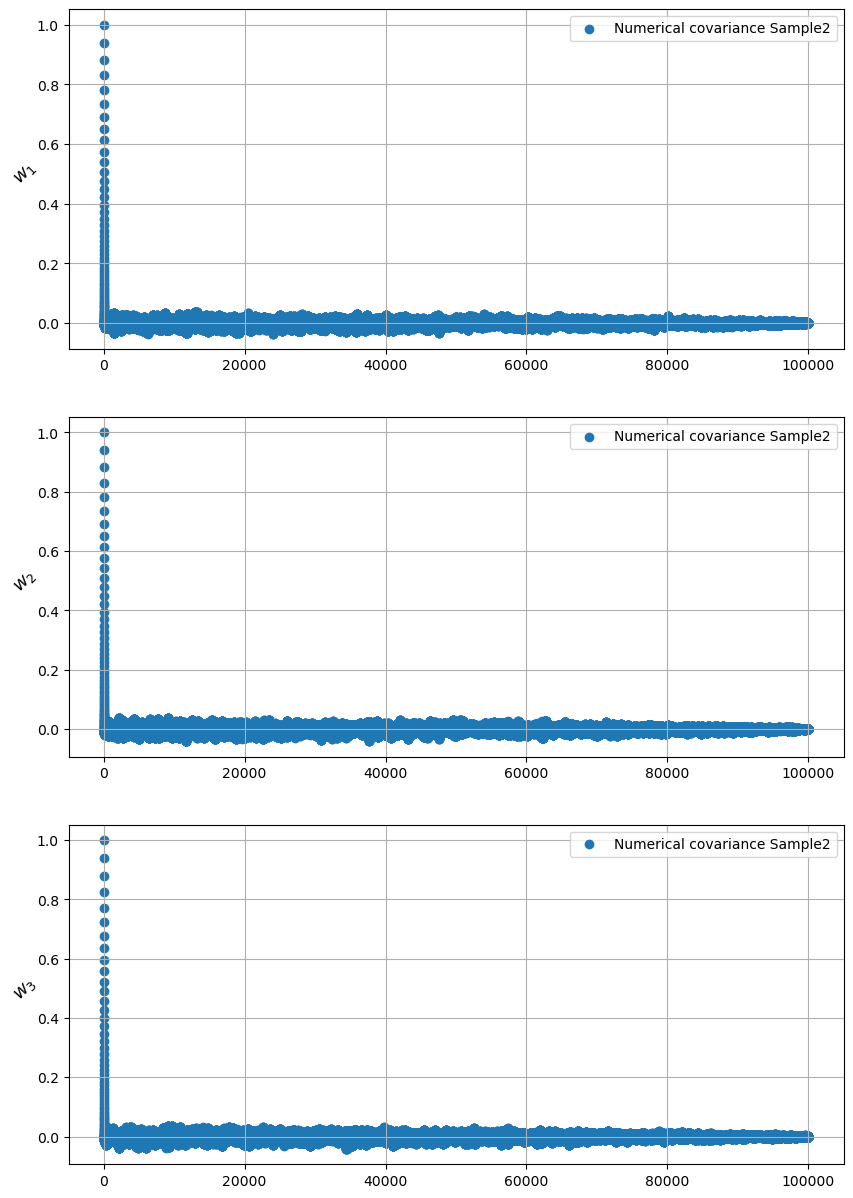

[2. 2. 2.]


In [18]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i
    
def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))
    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n
    # Optionally normalize
    if norm:
        acf /= acf[0]
    return acf

smp = np.transpose(samples2)
nn = len(samples2)
cors = np.zeros((n_pars,nn))

fig, axs = plt.subplots( n_pars, figsize = [10,15] )
x = np.arange(0, nn)
for i in range(n_pars):
    axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
    cors[i] = autocorr_func_1d(smp[i], norm=True)
    axs[i].scatter(x, cors[i], label = 'Numerical covariance Sample2')
    axs[i].grid()
    axs[i].legend()
plt.show()
plt.close()
taus = 1 + 2*np.sum(cors, axis = 1)
print(taus)

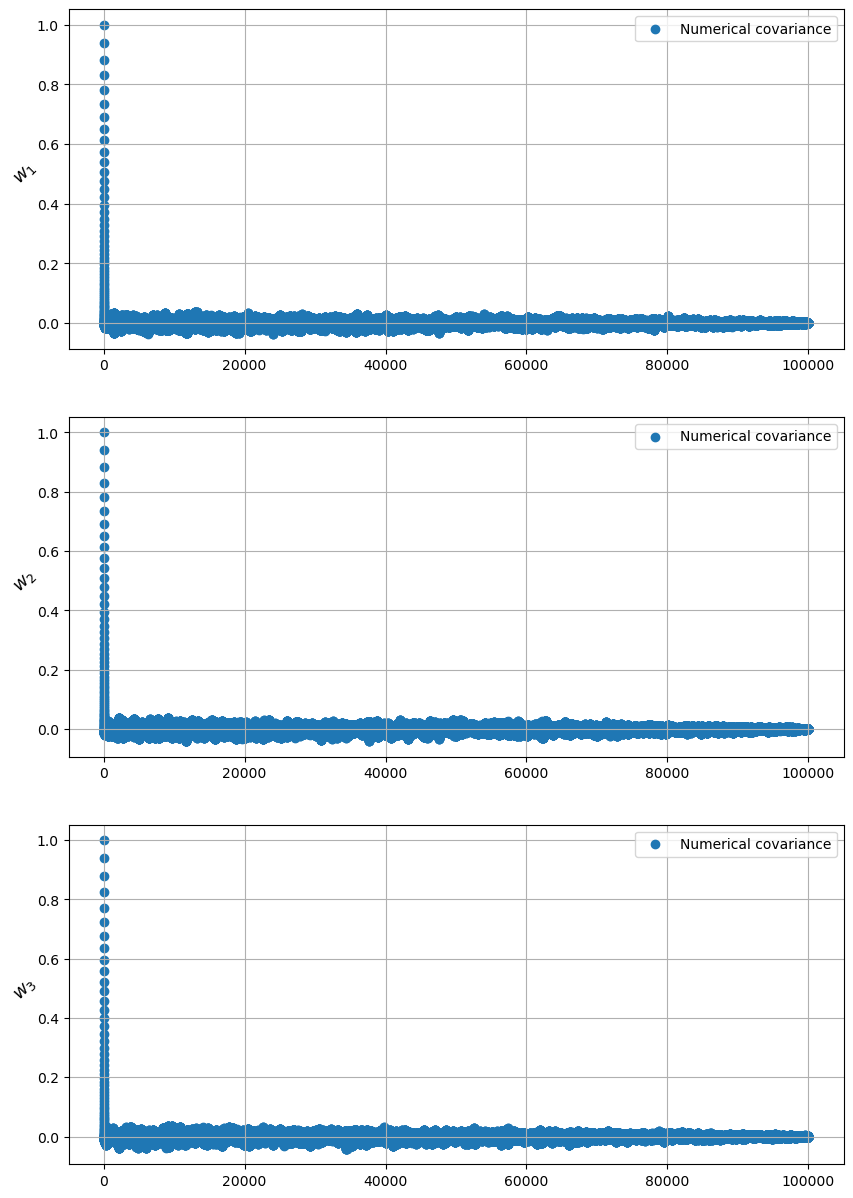

[2. 2. 2.]


In [19]:
smp = np.transpose(samples2)
nn = len(samples2)
cors = np.zeros((n_pars,nn))

def autocor(data):
    mean = np.mean(data)
    var = np.var(data)
    # Normalized data
    ndata = data - mean
    acorr = np.correlate(ndata, ndata, 'full')[len(ndata)-1:] 
    acorr = acorr / var / len(ndata)
    return acorr


fig, axs = plt.subplots( n_pars, figsize = [10,15] )
x = np.arange(0, nn)
for i in range(n_pars):
    axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
    cors[i] = autocor(smp[i])
    axs[i].scatter(x, cors[i], label = 'Numerical covariance')
    axs[i].grid()
    axs[i].legend()
plt.show()
plt.close()
taus = 1 + 2*np.sum(cors, axis = 1)
print(taus)